In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from keras.models import Model
from keras.layers import *
from keras import backend as K
from tensorflow.keras.utils import get_file
from keras.regularizers import l2

from sklearn.utils.class_weight import compute_class_weight


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [2]:
def plot_overlay(X_test, y_test, indices_to_plot=None):

    # Randomly sample indices if not provided
    if indices_to_plot is None:
        indices_to_plot = np.random.choice(X_test.shape[0], size=5, replace=False)

    num_samples = len(indices_to_plot)

    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices_to_plot):
        # Get the data for this index
        img = X_test[idx].squeeze()  # Remove channel dimension
        true_mask = y_test[idx]

        # Plot the original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img, cmap='gray')
        plt.title("Input Image")
        plt.axis("off")

        # Plot image with ground truth overlay
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(img, cmap='gray')  # Plot the image first
        plt.imshow(true_mask, cmap='viridis', alpha=0.5)  # Overlay the ground truth mask
        plt.title("Ground Truth Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
!ls /kaggle/input/cleaneddataset

augmented_dataset_2.npz  augmented_dataset_only_geom.npz  cleanedDataset.npz


In [3]:
data = np.load("/kaggle/input/cleaneddataset/cleanedDataset.npz")
augdata=np.load("/kaggle/input/augmented-relabeled-rocks/augmented_dataset_only_geom_2.npz")


X = augdata["images"]
y = augdata["masks"]

X_test = np.array(data["X_test"])
X_true = np.array(data["X_train"])
y_true = np.array(data["y_train"])


print(f"Training X shape: {X.shape}")
print(f"Training y shape: {y.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (14835, 64, 128, 1)
Training y shape: (14835, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [4]:
import albumentations as A
import random
import cv2


transform1 = A.Compose([
    A.RandomCrop(width=128, height=64, always_apply=True),  # Crop to keep dimensions consistent
    A.RandomGamma(gamma_limit=(40, 300), p=1),
    A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=0.7, p=1)
])


In [5]:
# List of transforms
transforms = [transform1]

# Augment the entire dataset and store the augmented images and masks
augmented_imagesTrain = []
augmented_masksTrain = []

# Assuming X_train and y_train are your dataset
# Apply 4 different augmentations to each image
for transform in transforms:
    for idx in range(len(X)):  # Iterate over each image in the dataset
        original_image = X[idx]
        original_mask = y[idx]

        # Ensure correct type for image and mask (float32 for image)
        original_image = np.float32(original_image)  # Convert image to float32
        original_mask = np.uint8(original_mask)  # Ensure mask is uint8

        # Apply the current transformation
        augmented = transform(image=original_image, mask=original_mask)
        aug_image = augmented['image']
        aug_mask = augmented['mask']

        # Ensure that images and masks are consistent in shape (128x64)
        aug_image = cv2.resize(aug_image, (128, 64))  # Resize image to ensure it's 128x64
        aug_mask = cv2.resize(aug_mask, (128, 64), interpolation=cv2.INTER_NEAREST)  # Resize mask to ensure it's 128x64

        # Make sure the image has 3 channels (if RGB) and the mask is single-channel
        if len(aug_image.shape) == 2:  # If the image is grayscale
            aug_image = np.expand_dims(aug_image, axis=-1)  # Add a channel dimension

        # Append augmented images and masks to the lists
        augmented_imagesTrain.append(aug_image)
        augmented_masksTrain.append(aug_mask)

# Convert lists to numpy arrays
X_train = np.array(augmented_imagesTrain)
y_train = np.array(augmented_masksTrain)

# Check shapes of the arrays
print(f"Augmented images shape: {X_train.shape}")
print(f"Augmented masks shape: {y_train.shape}")

# Check the saved dataset

Augmented images shape: (14835, 64, 128, 1)
Augmented masks shape: (14835, 64, 128)


In [6]:
# Split data into train_val and test sets
X_test1, X_val, y_test1, y_val = train_test_split(
    X_true,
    y_true,
    random_state=seed,
    test_size=0.6,
)



# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test1 shape: {X_test1.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (14835, 64, 128, 1), y_train shape: (14835, 64, 128)
X_val shape: (1503, 64, 128, 1), y_val shape: (1503, 64, 128)
X_test1 shape: (1002, 64, 128, 1)
X_test shape: (10022, 64, 128, 1)


In [7]:
# Flatten the train_labels array to get a 1D array of class labels across all pixels
train_labels_flat = y_train.flatten()  # Shape: (num_samples * height * width,)

# Remove class 0 (background) from the array to ignore it
train_labels_flat = train_labels_flat[train_labels_flat != 0]

# Compute class weights based on pixel distribution
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_labels_flat), 
    y=train_labels_flat
)

# Map the computed class weights back to the class indices (excluding class 0)
class_weight_dict = {i: class_weights[i - 1] for i in range(1, len(class_weights) + 1)}

# Print the class weights
print("Class Weights (ignoring class 0):")
print(class_weight_dict)


Class Weights (ignoring class 0):
{1: 0.7082331398689591, 2: 0.9194555073827303, 3: 0.9123234890882034, 4: 2.473209403177718}


In [8]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


In [10]:
# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 20

# Set maximum number of training epochs
EPOCHS = 1000

num_classes = 5

In [19]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

#-------------------------------------------------------------------------------------

from tensorflow.keras.backend import repeat_elements
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable(package="Custom", name="RepeatElementsLayer")
class RepeatElementsLayer(layers.Layer):
    def __init__(self, rep, axis=3, **kwargs):
        super().__init__(**kwargs)
        self.rep = rep
        self.axis = axis

    def call(self, inputs):
        return repeat_elements(inputs, self.rep, self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"rep": self.rep, "axis": self.axis})
        return config

# Usage
def repeat_elem(tensor, rep):
    return RepeatElementsLayer(rep=rep)(tensor)
#-------------------------------------------------------------------------------------

def res_conv_block(x, filter_size, size, dropout, batch_norm=True):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same', tfk.regularizers.l2(1e-4))(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same', tfk.regularizers.l2(1e-4))(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = tfk.layers.SpatialDropout2D(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same', tfk.regularizers.l2(1e-4))(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

#-------------------------------------------------------------------------------------

# resize the down layer feature map into the same dimension as the up layer feature map
def gating_signal(input, out_size, batch_norm=True):

    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

#-------------------------------------------------------------------------------------

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), padding='same')(phi_g)  

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

#-------------------------------------------------------------------------------------

def Attention_ResUNet(input_shape, NUM_CLASSES=num_classes, dropout_rate=0.4, batch_norm=True):
 
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

SyntaxError: positional argument follows keyword argument (2970953124.py, line 31)

In [20]:
input_shape = (64,128,1)
model = Attention_ResUNet(input_shape, num_classes)

# Display the number of trainable and non-trainable parameters
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
total_params = trainable_params + non_trainable_params

print(f"Trainable Parameters: {trainable_params}")
print(f"Non-trainable Parameters: {non_trainable_params}")
print(f"Total Parameters: {total_params}")

Trainable Parameters: 9776243
Non-trainable Parameters: 10762
Total Parameters: 9787005


In [21]:
# Use it in model.compile
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(ignore_class = 0),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])],
)
print("Model compiled!")

Model compiled!


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath="best_model.keras",  # File to save the best model
    monitor="val_mean_iou",       # Metric to monitor 
    save_best_only=True,      # Save only the best model
    mode="min"                # Lower values of val_loss are better
)

# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

# Define the learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # You can monitor 'loss' or 'val_loss'
    factor=0.5,  # Factor to reduce learning rate
    patience=7,  # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-6  # Minimum learning rate
)



In [23]:
# Train the model
history = model.fit(
    X_train,  # Features
    y_train,  # Labels
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping,lr_scheduler, checkpoint],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000


W0000 00:00:1734193491.080680      96 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


463/464 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3239 - loss: 1.3606 - mean_iou: 0.2227

W0000 00:00:1734193558.804162      97 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3241 - loss: 1.3602 - mean_iou: 0.2228

W0000 00:00:1734193594.053830      97 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734193598.760667      98 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


464/464 ━━━━━━━━━━━━━━━━━━━━ 139s 169ms/step - accuracy: 0.3242 - loss: 1.3598 - mean_iou: 0.2229 - val_accuracy: 0.2078 - val_loss: 3.0748 - val_mean_iou: 0.0793 - learning_rate: 0.0010
Epoch 2/1000
464/464 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.4589 - loss: 0.9083 - mean_iou: 0.3723 - val_accuracy: 0.4812 - val_loss: 0.8892 - val_mean_iou: 0.3605 - learning_rate: 0.0010
Epoch 3/1000
464/464 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.5141 - loss: 0.7075 - mean_iou: 0.5116 - val_accuracy: 0.5762 - val_loss: 0.6166 - val_mean_iou: 0.4993 - learning_rate: 0.0010
Epoch 4/1000
464/464 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.5527 - loss: 0.5669 - mean_iou: 0.6495 - val_accuracy: 0.5555 - val_loss: 0.6506 - val_mean_iou: 0.4572 - learning_rate: 0.0010
Epoch 5/1000
464/464 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.5796 - loss: 0.4615 - mean_iou: 0.7102 - val_accuracy: 0.5862 - val_loss: 0.5774 - val_mean_iou: 0.5359 - learning_rate: 0.0010
Epoch 6/1000
464/464 

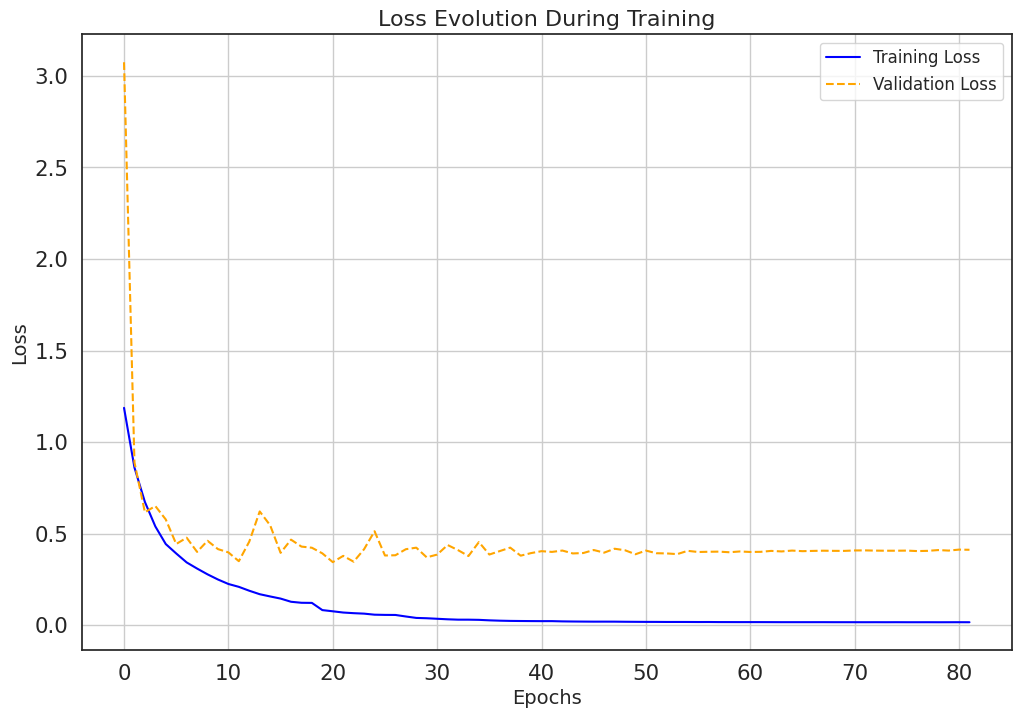

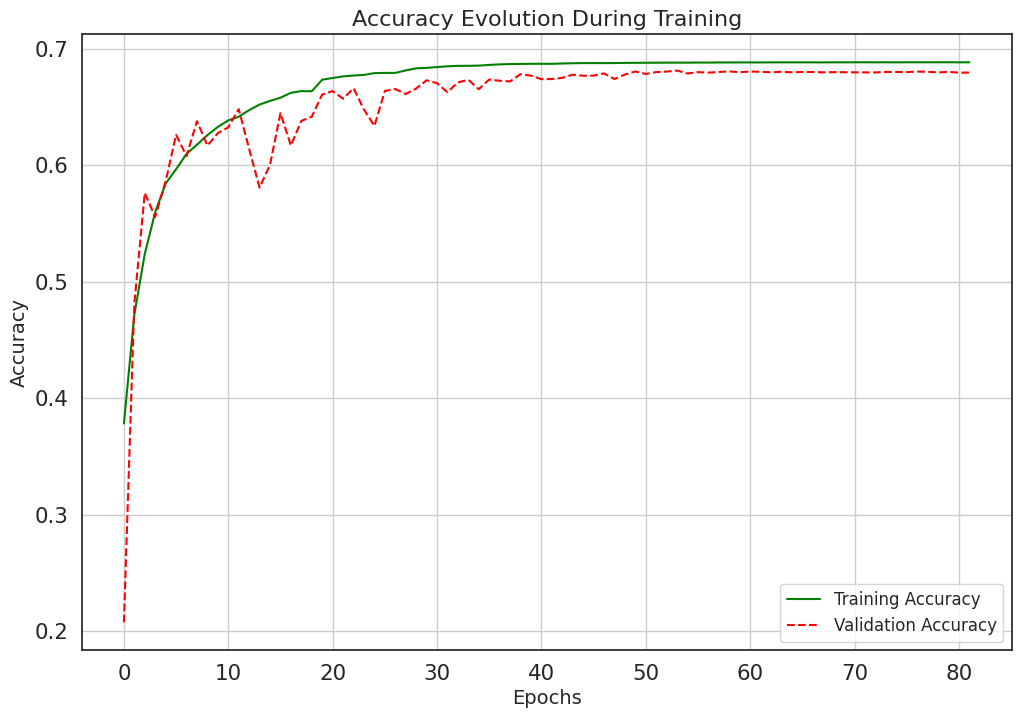

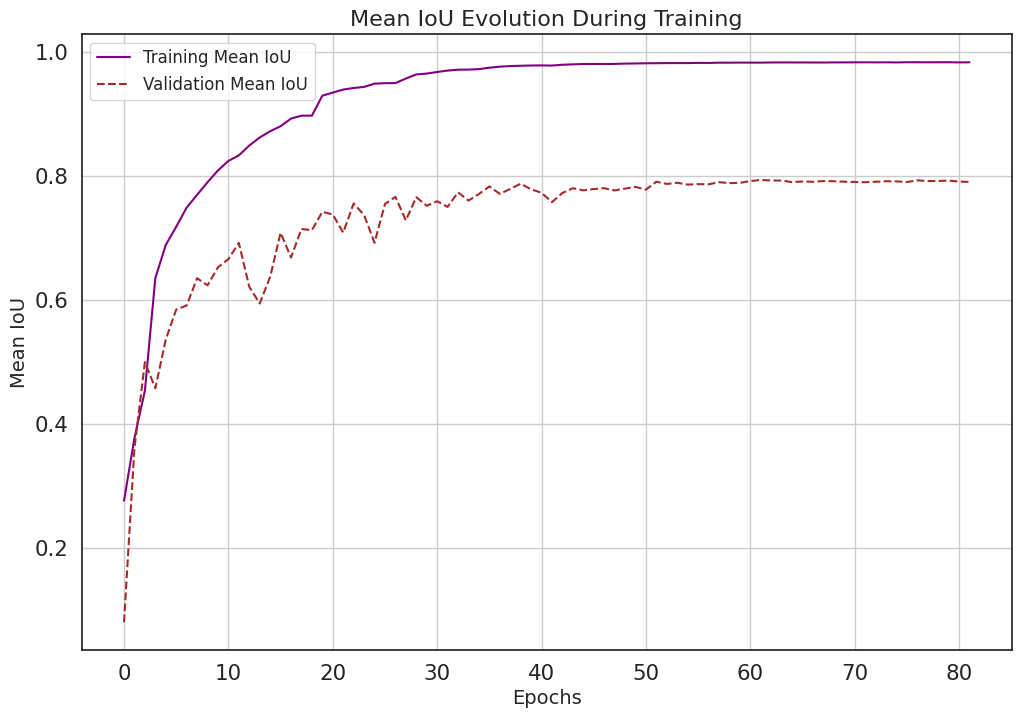

In [24]:
import matplotlib.pyplot as plt

# Extract values from history
epochs = range(len(history['loss']))

# Plot Training and Validation Loss 
plt.figure(figsize=(12, 8))
plt.plot(epochs, history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Loss Evolution During Training', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True) 
plt.show()

# Plot Training and Validation Accuracy
if 'accuracy' in history and 'val_accuracy' in history:
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
    plt.title('Accuracy Evolution During Training', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Plot Training and Validation Mean IoU
if 'mean_iou' in history and 'val_mean_iou' in history:
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history['mean_iou'], label='Training Mean IoU', color='purple', linestyle='-')
    plt.plot(epochs, history['val_mean_iou'], label='Validation Mean IoU', color='brown', linestyle='--')
    plt.title('Mean IoU Evolution During Training', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Mean IoU', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [25]:
model = tf.keras.models.load_model('/kaggle/working/UNet_79.35.keras', compile=False)

In [26]:
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(ignore_class = 0),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
print("Model compiled!")



Model compiled!


In [28]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
Predictions shape: (10022, 64, 128)


In [29]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [30]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)


In [168]:
del model